# Spectral Clustering


Aim: Use spectral methods on graph clustering.


Install [numpy](https://docs.scipy.org/doc/numpy-1.13.0/user/install.html) and [sklearn](http://scikit-learn.org/stable/) . Use this command `pip install --user numpy` and `pip install --user sklearn` to install numpy on your machine. 

Following helper function is needed.

In [1]:
%matplotlib inline
from pylab import *
import random as rnd
import networkx as nx
import numpy as np
from __future__ import division

rnd.seed(2333)

def draw_graph(graph, labels=None, graph_layout='spring',
               node_size=1600, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):
    """ 
    Based on: https://www.udacity.com/wiki/creating-network-graphs-with-python
    We describe a graph as a list enumerating all edges.
    Ex: graph = [(1,2), (2,3)] represents a graph with 2 edges - (node1 - node2) and (node2 - node3)
    """
    
    rcParams['figure.figsize'] = 12, 12  # that's default image size for this interactive session
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network 
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)
    # show graph
    plt.show()

## Representing Graphs as Adjacency Matrix 

Represent a graph using an adjacency matrix `A`, where `A[i,j] = 1` indicates there is an edge between node `i` and node `j` and `A[i,j] = 0` indicates there is no edge in between. For simplicity, we will represent `A` using a numpy array.

For visualization, write a function that convert the randomly generated graphs (as an adjacency matrix) into its a list of edge tuples.

In [2]:
def adjacency_to_graph(adjacency):
    assert all(adjacency == adjacency.T)
    graph = []
    
    #findinf position in adjacency matrix where value=1
    x=np.argwhere(adjacency == 1)
    for i in range(x.shape[0]):
        if (x[i][1],x[i][0]) not in graph :#to remove redundancy
            
            graph.append(tuple(x[i]))
    return graph

[(0, 1), (0, 2), (1, 2)]


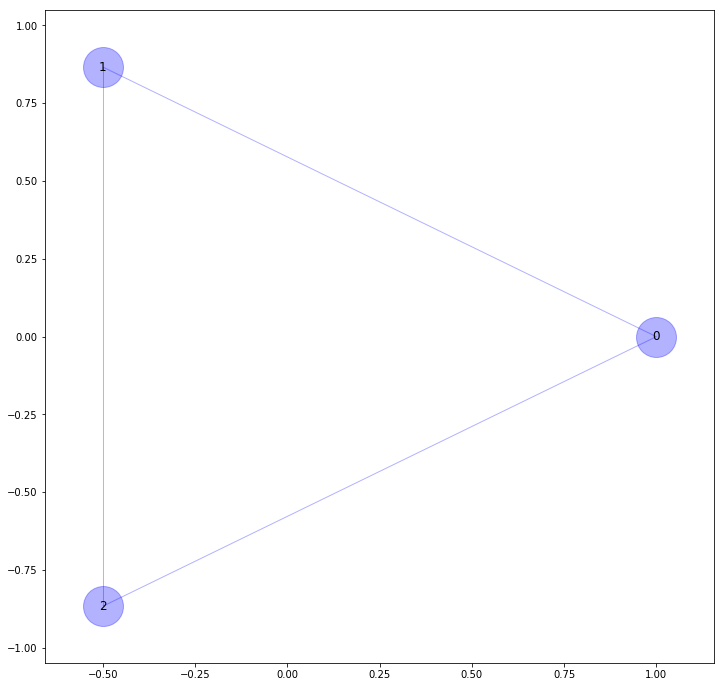

In [3]:
# sanity check
adjacency = np.array([[0, 1, 1], 
                      [1, 0, 1], 
                      [1, 1, 0]])

graph = adjacency_to_graph(adjacency)
print graph
draw_graph(graph, graph_layout='shell')



##  Erdős-Rényi Graphs 
. 
The Erdős-Rényi model(http://www.renyi.hu/~p_erdos/1959-11.pdf) states that given $n$ nodes, any pair of nodes $(i,j)$ are connected with probability $p$.


Create an Erdős–Rényi random graph ${G}(n,p)$. For each pair of nodes, randomly create an edge between them with probability $p$. Return the resulting graph as its adjacency matrix. 

In [4]:
import itertools
comb=itertools.combinations(range(5),2)
print list(comb)
def G(n, p):
    '''
    output a graph by its adjacency matrix
    '''
    #possible combination of vertices to form and edge in an graph
    cmb=itertools.combinations(range(n),2)
    comb=list(cmb)
    graph = np.zeros((n, n))
    #randomly create an edge between them with probability  p
    edges=rnd.sample(comb,int(p*len(comb)))
    for i in edges:
        #assigning value 1 correspondinf to vertices i,j if they form an edge
        graph[i[0]][i[1]]=1
        graph[i[1]][i[0]]=1
    return graph
range(1,5)

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


[1, 2, 3, 4]

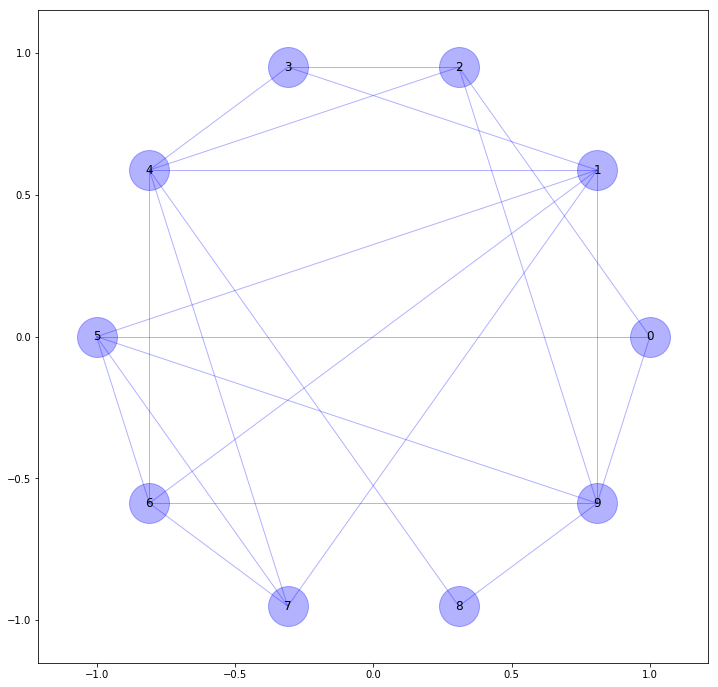

In [5]:
# visualize this randomly generated graph
graph = adjacency_to_graph(G(10, 0.5))
draw_graph(graph, graph_layout='shell')

## Stochastic Block Model 

The [stochastic block model](https://en.wikipedia.org/wiki/Stochastic_block_model) (SBM) is a generative model for random graphs. This model tends to produce graphs containing communities. SBM is parameterized by $n$, $k$, $p$ and $q$: $n$ is the number of vertices, $k$ is the number of communities, $p$ is the probability of an edge existing between any two nodes within a community and $q$ is the probabiloty of an edge between two communities. We are interested in recovering the communities from a realization of the random graph.

For simplicity, we assume $n$ is a multiple of $k$, and node $i$ belongs to community $l$ iff $l\frac{n}{k} \le i < (l+1)\frac{n}{k}$, for all $i=0,1,...,n-1$ and $l=0,1,...,k-1$. 


In [6]:
def SBM(n, k, p, q):
    '''
    output a graph by a list of edge tuples

    '''
    assert (n % k == 0)
    graph = np.zeros((n, n))
    sub_graph=[]
    inter_edge=[]

    for i in range(k):
        #generating intra graph communities by using Erdős-Rényi Graphs
        graph_cluster=adjacency_to_graph(G(int(n/k), p))
        for g in graph_cluster:
            g=list(g)
            x=g[0]+(n/k*i)
            y=g[1]+(n/k*i)
            graph[int(x)][int(y)]=1
            graph[int(y)][int(x)]=1
        sub_graph.append(range(int(n/k*i),int((n/k*i)+n/k)))
        #print adjacency_to_graph(graph)
   
    #Assigning the inter graph communities edges
    choose_clusters=itertools.combinations(sub_graph,2)
    for pairs in choose_clusters:
        c=[]
        a = pairs[0]
        b = pairs[1]
        c = list(itertools.product(a, b))
        inter_edge+=c  
    inter_edges=rnd.sample(inter_edge,int(q*len(inter_edge)))
    for j in inter_edges:
            graph[j[0]][j[1]]=1
            graph[j[1]][j[0]]=1
    return graph


Try it out.

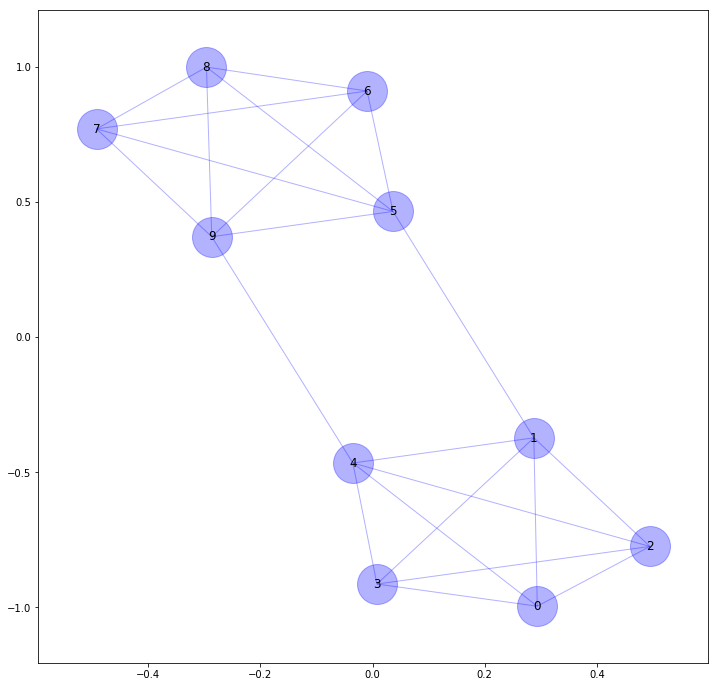

In [7]:
graph = adjacency_to_graph(SBM(10, 2, 1, 0.1))
draw_graph(graph)

## Laplacian of the Graph 

Once we have the adjacency matrix $A$ of the given graph, it's easy to calculate its [Laplacians](https://en.wikipedia.org/wiki/Laplacian_matrix) for spectral clustering. 

The Laplacian of a graph is defined as $L = D-A$, where $A$ is its adjacency matrix and $D$ is the degree matrix. Specifically, $D(i, i) = {\rm degree}(i)$ and $D(i,j) = 0$ for any $i\neq j$.

Fill in the following function to compute the Laplacian of the graph.

In [8]:
def get_laplacian(adjacency):
    '''
    return the Laplacian.
    '''
    laplacian = np.zeros(adjacency.shape)
    laplacian=(-1)*adjacency
    for i in range(adjacency.shape[0]):
        degree=list(adjacency[i]).count(1)
        #print degree
        laplacian[i][i]=degree
    return laplacian

adjacency = np.array([[0, 1, 0, 0, 1, 0],
                      [1, 0, 1, 0, 1, 0],
                      [0, 1, 0, 1, 0, 0],
                      [0, 0, 1, 0, 1, 1],
                      [1, 1, 0, 1, 0, 0],
                      [0, 0, 0, 1, 0, 0]])
get_laplacian(adjacency)

array([[ 2, -1,  0,  0, -1,  0],
       [-1,  3, -1,  0, -1,  0],
       [ 0, -1,  2, -1,  0,  0],
       [ 0,  0, -1,  3, -1, -1],
       [-1, -1,  0, -1,  3,  0],
       [ 0,  0,  0, -1,  0,  1]])

## Spectral Clustering 

The smallest eigenvalue of $L$ is equal to zero because $L$ times the all 1s vector is equal to zero. The next $k-1$ smallest eigenvalues usually determine the number of clusters. In other words, if you can find $k-1$ eigenvalues that are very close to zero, then the graph has $k$ commnunities. 

Spectral clustering uses the Laplacian $L$ with priori information on $k$. The inputs are the adjacency matrix $A$ and the number of clusters to be recovered. The first step consists in computing the eigenvectors corresponding to the lowest $k$ eigenvalues of $L$. 

Filling the function to get the eigenvectors of the Laplacian.

In [9]:
def get_vectors(laplacian, k):
    X=[]
    v = np.zeros((len(laplacian), k))
    #w:eigen values
    #vx:eigen vectors
    w,vx=np.linalg.eig(laplacian)
    
    #ordering the eigen values
    order = w.argsort()
    icr_w=order.argsort()
    icr_w=np.array(icr_w)
    for i in range(vx.shape[1]):
        X.append(vx[:,i])
    X=np.array(X)
    
    #ordering the eigen vectors in incresing order 
    #correspoding to eigen values
    sorted_columns_v= [j for _,j in sorted(zip(icr_w,X))]
    
    #choosing  eigenvectors corresponding to the lowest  k
    #eigenvalues of  L
    for i in range(v.shape[1]):
        v[:,i]=sorted_columns_v[i]
        
    return v
v=get_vectors(get_laplacian(adjacency), 3)
len(v)

6

Then one builds the $n\times k$ matrix $V$, whose colums are the $k$ eigenvectors. The $n$ rows of $V$ are used to represent the graph vertices in a $k$-dimensional Euclidean space. The points are then grouped in $k$ clusters by using $k$-means clustering. 

Fill in the code to perform $k$-means clustering on the $n\times k$ eigenvector $V$. The output is a $n$-dimensional vector where the $i$-th entry represents which cluster node $i$ belongs to. You may find [this page](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) useful. 

In [10]:
from sklearn.cluster import KMeans
def kmeans(v, k):
    labels = np.zeros(len(v))
    kmeans=KMeans(n_clusters=k, random_state=None).fit(v)
    labels=kmeans.labels_
    #print len(labels)
    return labels
kmeans(v, 3) 

array([1, 1, 0, 0, 1, 2], dtype=int32)

Assembly the code to implement an end-to-end spectral clustering on graphs. The inputs are the adjacency matrix of this graph $A$, and the number of cluster $k$. 

In [11]:
def spectral_clustering(A, k):
    labels = np.zeros(len(A))
    # get its laplacian
    laplacian=get_laplacian(A)
    # get the eigenvectors
    eigenvectors=get_vectors(laplacian, k)
    # perform k-means clustering on eigenvectors
    labels=kmeans(eigenvectors,k)
    # return the label
    return labels

Recall the problem setup: we are given a graph of connections, and we know that the nodes belong to $k$ communities. Intuitively, we expect the $n/k$ nodes in the same community to have more connections amongst each other than with the rest of the nodes nodes. 

Consider the following toy example where $n=6$ and $k=2$.
<img src="http://i.imgur.com/JAPqQNf.png" width="400" height="400" />
We are given the above graph and would like to recover the community assignments.  Perhaps it is clear by inspection that the proper community assignments should be:
<img src="http://i.imgur.com/Ec2Xehs.png" width="450" height="450" />

A good metric to evaluate the clustering algorithm is the total number of edges across clusters, formally defined as follows,
$${\tt num\_edges} = \sum_{i, j:{\tt labels(i) \neq labels(j)}} A(i, j)$$

Looking back at the toy example above we can see that the number of inter-cluster edges is 1. This number is uniquely determined by the graph partition (i.e. `labels`) and the adjacency matrix. Fill in the following function to compute the number of inter-cluster edges. 

In [16]:
def inter_cluster_edges(A, labels):
    num_edges = 0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            #checking if the vertices belong to diifrent clusters
            if labels[i]!=labels[j]:
                #if true and there is edge between them
                if A[i][j]==1:
                    #increment the intercluster edges
                    num_edges+=1
    
    return num_edges/2

In the graphs we create, we know that the nodes $(l\frac{n}{k}, (l+1)\frac{n}{k})$ form the $l$-th cluster.  Let $p = 0.5$ and $q$ varies from 0 to 1. We test the spectral clustering via realizations of stochastic block model. For each ($p$, $q$) pair, we do `L = 100` trials. The performance of spectral clustering can be compared with the ground truth.

/Users/shruti/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


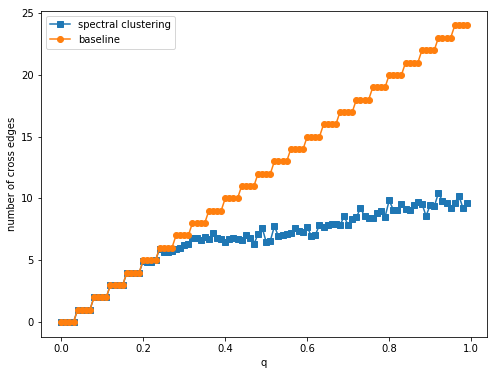

In [17]:
L = 100 # number of iterations to average over
n = 10
ground_truth = np.array([0,0,0,0,0,1,1,1,1,1])
k = 2
p = 0.8
qs = np.arange(0, 1, 0.01)
num_edges = np.zeros((len(qs), L))
baselines = np.zeros((len(qs), L))
for i, q in enumerate(qs):
    for l in xrange(L):
        adjacency = SBM(n, k, p, q)
        labels = spectral_clustering(adjacency, k)
        #print len(labels)
        num_edges[i, l] = inter_cluster_edges(adjacency, labels)
        baselines[i, l] = inter_cluster_edges(adjacency, ground_truth)
        
rcParams['figure.figsize'] = 8, 6
plt.figure()
plt.plot(qs, np.average(num_edges, axis=1), marker='s', label='spectral clustering')
plt.plot(qs, np.average(baselines, axis=1), marker='o', label='baseline')
plt.legend()
plt.xlabel('q')
plt.ylabel('number of cross edges')
plt.show()

Try this code with different `p` and `q`. What happened? Can you think of an explanation why this phenomenon happens?




/Users/shruti/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


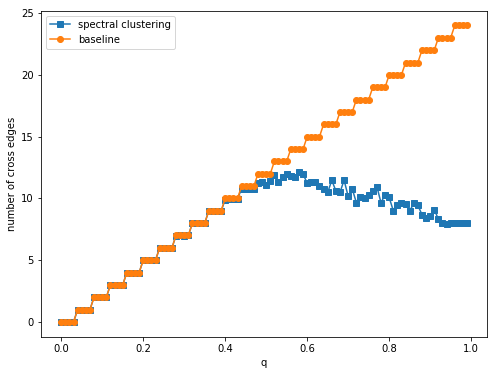

In [18]:
#p=1
L = 100 # number of iterations to average over
n = 10
ground_truth = np.array([0,0,0,0,0,1,1,1,1,1])
k = 2
p = 1
qs = np.arange(0, 1, 0.01)
num_edges = np.zeros((len(qs), L))
baselines = np.zeros((len(qs), L))
for i, q in enumerate(qs):
    for l in xrange(L):
        adjacency = SBM(n, k, p, q)
        labels = spectral_clustering(adjacency, k)
        #print len(labels)
        num_edges[i, l] = inter_cluster_edges(adjacency, labels)
        baselines[i, l] = inter_cluster_edges(adjacency, ground_truth)
        
rcParams['figure.figsize'] = 8, 6
plt.figure()
plt.plot(qs, np.average(num_edges, axis=1), marker='s', label='spectral clustering')
plt.plot(qs, np.average(baselines, axis=1), marker='o', label='baseline')
plt.legend()
plt.xlabel('q')
plt.ylabel('number of cross edges')
plt.show()

/Users/shruti/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0,0.5,u'number of cross edges')

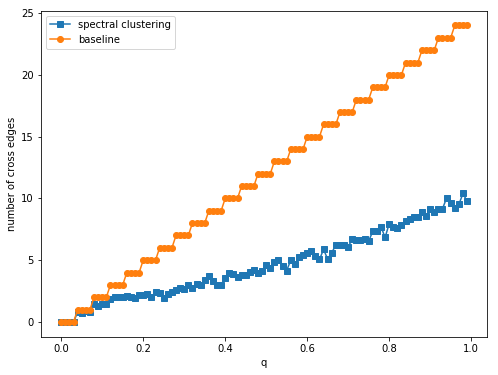

In [20]:
#p=0.5
L = 100 # number of iterations to average over
n = 10
ground_truth = np.array([0,0,0,0,0,1,1,1,1,1])
k = 2
p = 0.5
qs = np.arange(0, 1, 0.01)
num_edges = np.zeros((len(qs), L))
baselines = np.zeros((len(qs), L))
for i, q in enumerate(qs):
    for l in xrange(L):
        adjacency = SBM(n, k, p, q)
        labels = spectral_clustering(adjacency, k)
        #print len(labels)
        num_edges[i, l] = inter_cluster_edges(adjacency, labels)
        baselines[i, l] = inter_cluster_edges(adjacency, ground_truth)
        
rcParams['figure.figsize'] = 8, 6
plt.figure()
plt.plot(qs, np.average(num_edges, axis=1), marker='s', label='spectral clustering')
plt.plot(qs, np.average(baselines, axis=1), marker='o', label='baseline')
plt.legend()
plt.xlabel('q')
plt.ylabel('number of cross edges')
#plt.show()

1) As p increases there is a better overlap between baseline and spectral clustering plots even at higher q values.

2) lower q values show better simmilarity to the baseline plot compared to higher q values

A lower q value signifies lesser interedges between clusters(less connectivity between clusters) and high p values indicate more intra cluster edges (showing high connectivity or relationships between elements within a clusters). Thus, low q values and high p values show lesser connectivity between clusters and higher connectivity within cluster. Therefore, allowing to uniquely classify a cluster with better accuracy.

Inorder to assign labels to clusters similar to the ground truth, the nodes in a graph should be classified into clusters in such a way that it maximises p and minimises q(q=0: ideal).